In [10]:
import numpy as np
import cv2
import torch
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
def convolution(input_matrix, kernel):
    input_height, input_width = input_matrix.shape
    kernel_height, kernel_width = kernel.shape

    output_height = input_height - kernel_height + 1
    output_width = input_width - kernel_width + 1

    output_matrix = np.zeros((output_height, output_width))

    for i in range(output_height):
        for j in range(output_width):
            output_matrix[i, j] = np.sum(input_matrix[i:i+kernel_height, j:j+kernel_width] * kernel)

    return output_matrix


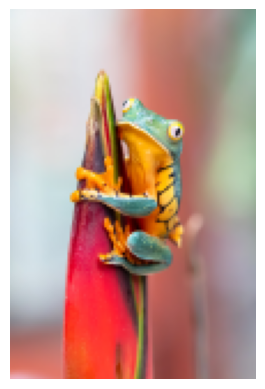

In [66]:
image_path = "/content/drive/MyDrive/Colab Data/stephanie.jpg"

bgr_image = cv2.imread(image_path)
rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

scale_percent = 0.04
width = int(rgb_image.shape[1] * scale_percent)
height = int(rgb_image.shape[0] * scale_percent)
dim = (width, height)
rgb_image = cv2.resize(rgb_image, dim, interpolation = cv2.INTER_AREA)
plt.axis('off')
plt.imshow(rgb_image)

In [48]:
rgb_image.shape

(161, 107, 3)

In [49]:
transform = transforms.ToTensor()
image_tensor = transform(rgb_image)

## Gaussian filter

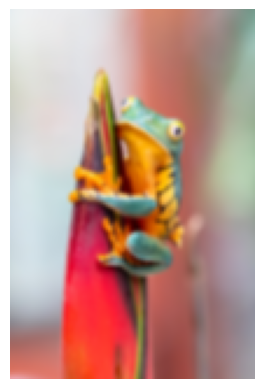

In [50]:
# Gaussian-filter
gaussian_kernel = torch.tensor([[1, 2, 1],
                                [2, 4, 2],
                                [1, 2, 1]], dtype=torch.float32)
gaussian_kernel = gaussian_kernel / gaussian_kernel.sum()           #Normalization


filtered_channels = [convolution(channel.numpy(), gaussian_kernel.numpy()) for channel in image_tensor]

filtered_r = torch.tensor(filtered_channels[0])
filtered_g = torch.tensor(filtered_channels[1])
filtered_b = torch.tensor(filtered_channels[2])

filtered_image = torch.stack((filtered_r, filtered_g, filtered_b), dim=0)

filtered_image = filtered_image.unsqueeze(0)

plt.imshow(filtered_image.squeeze().permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()


## Box filter

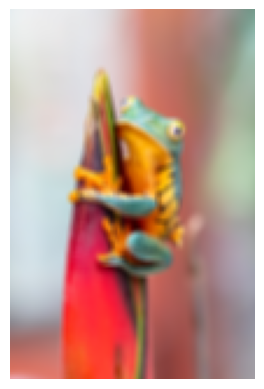

In [51]:
# Box-filter
box_kernel = torch.tensor([[1, 1, 1],
                           [1, 1, 1],
                           [1, 1, 1]], dtype=torch.float32)
box_kernel = box_kernel / box_kernel.sum()

filtered_channels = [convolution(channel.numpy(), box_kernel.numpy()) for channel in image_tensor]

filtered_r = torch.tensor(filtered_channels[0])
filtered_g = torch.tensor(filtered_channels[1])
filtered_b = torch.tensor(filtered_channels[2])

filtered_image = torch.stack((filtered_r, filtered_g, filtered_b), dim=0)

filtered_image = filtered_image.unsqueeze(0)

plt.imshow(filtered_image.squeeze().permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()

## Unsharp masking

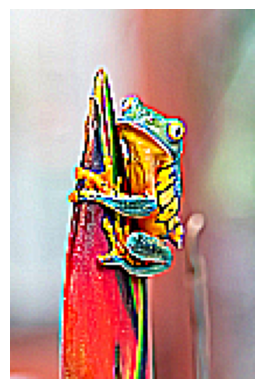

In [52]:
# Unsharp masking
unsharp_kernel = torch.tensor([[-1, -1, -1],
                               [-1,  9, -1],
                               [-1, -1, -1]], dtype=torch.float32)

filtered_channels = [convolution(channel.numpy(), unsharp_kernel.numpy()) for channel in image_tensor]

filtered_r = torch.tensor(filtered_channels[0])
filtered_g = torch.tensor(filtered_channels[1])
filtered_b = torch.tensor(filtered_channels[2])

filtered_image = torch.stack((filtered_r, filtered_g, filtered_b), dim=0)

filtered_image = filtered_image.unsqueeze(0)

plt.imshow(filtered_image.squeeze().permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()

## Sobel operator

(-0.5, 106.5, 160.5, -0.5)

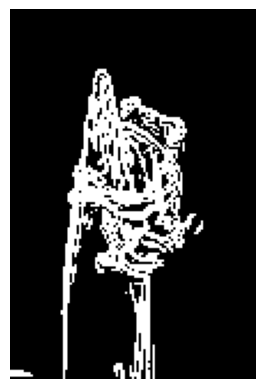

In [64]:
gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)

sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

threshold = 100
edges = (gradient_magnitude > threshold).astype(np.uint8) * 255

plt.imshow(edges, cmap='gray')
plt.axis('off')

## Min-Max Normalization:
Нормалізація Min-max масштабує значення пікселів до певного діапазону, зазвичай від 0 до 1.

In [74]:
def min_max_normalize(image):
    min_value = np.min(image)
    max_value = np.max(image)
    normalized_image = (image - min_value) / (max_value - min_value)
    return normalized_image

normalized_image = min_max_normalize(rgb_image)

normalized_image[0][:10]

array([[0.89411765, 0.9254902 , 0.93333333],
       [0.89803922, 0.92941176, 0.9372549 ],
       [0.90980392, 0.93333333, 0.94117647],
       [0.91764706, 0.9372549 , 0.94509804],
       [0.92156863, 0.94117647, 0.94901961],
       [0.9254902 , 0.94117647, 0.94901961],
       [0.9254902 , 0.94117647, 0.94509804],
       [0.93333333, 0.9372549 , 0.94509804],
       [0.93333333, 0.9372549 , 0.94509804],
       [0.93333333, 0.9372549 , 0.94509804]])

До нормалізації

In [73]:
rgb_image[0][:10]

array([[228, 236, 238],
       [229, 237, 239],
       [232, 238, 240],
       [234, 239, 241],
       [235, 240, 242],
       [236, 240, 242],
       [236, 240, 241],
       [238, 239, 241],
       [238, 239, 241],
       [238, 239, 241]], dtype=uint8)

## Image Standardization:
Стандартизація зображення передбачає віднімання середнього значення пікселя від кожного пікселя і ділення його на стандартне відхилення. Цей процес центрує значення пікселів навколо нуля і масштабує їх до одиничної дисперсії.

In [76]:
def standardize_image(image):
    mean_value = np.mean(image)
    std_value = np.std(image)
    standardized_image = (image - mean_value) / std_value
    return standardized_image

standardized_image = standardize_image(rgb_image)
standardized_image[0][:10]

array([[1.17343424, 1.3014051 , 1.33339781],
       [1.18943059, 1.31740145, 1.34939417],
       [1.23741967, 1.33339781, 1.36539053],
       [1.26941238, 1.34939417, 1.38138688],
       [1.28540874, 1.36539053, 1.39738324],
       [1.3014051 , 1.36539053, 1.39738324],
       [1.3014051 , 1.36539053, 1.38138688],
       [1.33339781, 1.34939417, 1.38138688],
       [1.33339781, 1.34939417, 1.38138688],
       [1.33339781, 1.34939417, 1.38138688]])

## Висновок

У цій роботі ми виконували різні завдання обробки зображень за допомогою Python, OpenCV і PyTorch. Ми почали із завантаження зображення, перетворення його у формат RGB і застосування фільтра Гауса для згладжування зображення, що допомагає зменшити шум і покращити деталі зображення. Ми також продемонстрували, як правильно нормалізувати зображення, щоб підготувати його до подальшого аналізу.

Далі ми заглибились у визначення країв за допомогою оператора Sobel. Ми перетворили зображення на відтінки сірого, застосували оператори Собела в обох напрямках x і y і обчислили величину градієнта для виявлення країв. Регулюючи поріг, ми могли контролювати чутливість виявлення країв, надаючи потужний інструмент для виділення функцій у програмах комп’ютерного зору.

Нарешті, ми досліджували методи нормалізації зображення, включаючи нормалізацію мінімум-максимум і стандартизацію зображення. Мінімально-максимальна нормалізація перемасштабує значення пікселів до певного діапазону, як правило, від 0 до 1, що робить його придатним для певних типів попередньої обробки даних. З іншого боку, стандартизація зображення центрує значення пікселів навколо нуля та масштабує їх, щоб мати одиничну дисперсію, що є цінним для покращення конвергенції під час навчання моделі глибокого навчання.

Роботу виконав </br>
*Бірук Сергій* </br>
*група КІ-31мп*